In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
import scipy.linalg
import pandas as pd
import sklearn
# import scipy.sparse
# import scipy.sparse.linalg
# import matplotlib
# import matplotlib.transforms
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
# import mpl_toolkits.mplot3d.axes3d as p3
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from matplotlib import animation
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [3]:
%ls

1 advanced/
1 basic/
Data-prediction-examples.ipynb
Data-prediction.ipynb
LICENSE
Makefile
ODI-2019-csv.csv
README.md
Springer_Guidelines_for_Authors_of_Proceedings.pdf


In [4]:
# %cat ODI-2019-csv.csv

In [5]:
data = pd.read_csv('ODI-2019-csv.csv', sep=';')

In [6]:
data.describe()

,Timestamp,What programme are you in?,Have you taken a course on machine learning?,Have you taken a course on information retrieval?,Have you taken a course on statistics?,Have you taken a course on databases?,What is your gender?,Chocolate makes you.....,When is your birthday (date)?,Number of neighbors sitting around you?,Did you stand up?,"You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then?",Give a random number,Time you went to be Yesterday,What makes a good day for you (1)?,What makes a good day for you (2)?,What is your stress level (0-100)?
count,276,276,276,276,276,276,276,276,276,276,276,276,276,276,276,276,275
unique,89,103,3,3,3,3,3,5,265,42,3,82,70,124,172,208,67
top,4/1/2019 16:01:40,AI,yes,0,mu,ja,male,neither,1995,2,no,100,7,23:00,Sun,Food,0
freq,11,55,171,156,242,143,182,90,7,56,249,39,52,18,32,14,35


In [7]:
data.head()

,Timestamp,What programme are you in?,Have you taken a course on machine learning?,Have you taken a course on information retrieval?,Have you taken a course on statistics?,Have you taken a course on databases?,What is your gender?,Chocolate makes you.....,When is your birthday (date)?,Number of neighbors sitting around you?,Did you stand up?,"You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then?",Give a random number,Time you went to be Yesterday,What makes a good day for you (1)?,What makes a good day for you (2)?,What is your stress level (0-100)?
0,3/27/2019 10:16:11,AI,yes,1,mu,ja,unknown,slim,unknown,3,no,100,6,23:00,sun,lecture,NaN
1,4/1/2019 15:58:21,AI,no,0,mu,ja,male,fat,09071992,1,no,0,7,3,DM,AI,1
2,4/1/2019 15:59:07,Computer Science,yes,1,unknown,ja,male,neither,04/08/95,0,unknown,0,0,0,0,0,100
3,4/1/2019 15:59:30,Econometrics,yes,1,mu,ja,male,fat,29-09-1993,2,no,42,"1,645","0,3",Winning,Food,0
4,4/1/2019 15:59:58,cs,no,1,mu,ja,male,neither,0212,2,no,second,66,20,kiss,love,100


In [8]:
{i:k for i,k in enumerate(data.keys())}

{0: 'Timestamp',
 1: 'What programme are you in?',
 2: 'Have you taken a course on machine learning?',
 3: 'Have you taken a course on information retrieval?',
 4: 'Have you taken a course on statistics?',
 5: 'Have you taken a course on databases?',
 6: 'What is your gender?',
 7: 'Chocolate makes you.....',
 8: 'When is your birthday (date)?',
 9: 'Number of neighbors sitting around you?',
 10: 'Did you stand up?',
 11: 'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ',
 12: 'Give a random number',
 13: 'Time you went to be Yesterday',
 14: 'What makes a good day for you (1)?',
 15: 'What makes a good day for you (2)?',
 16: 'What is your stress level (0-100)?'}

In [40]:
def translate(key):
    translations = {'What programme are you in?': 'Program', 
                   'Have you taken a course on machine learning?': 'ML',
                    'Have you taken a course on information retrieval?':'IR',
                    'Have you taken a course on statistics?':'Stat',
                    'Have you taken a course on databases?':'DB'}
    if key not in translations.keys():
        return key[-10:]
    return translations[key]

In [9]:
keys = data.keys()[[1,2,3,4]]

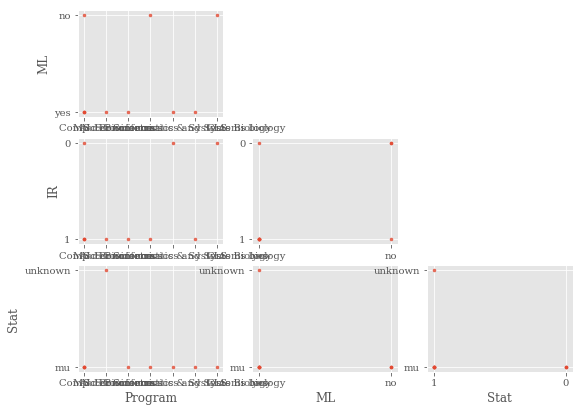

In [62]:
with plt.style.context(('ggplot')):
    n_items = 10
    n_keys = len(keys)
    plt.figure(figsize=(12,9))
    # x
    for i_x, k_x in enumerate(keys):
        # y
        for i_y, k_y in enumerate(keys):
            if i_x < i_y:
                plt.subplot(n_keys, n_keys, i_x + i_y * n_keys + 1)
                x = getattr(data, k_x)[:n_items]
                y = getattr(data, k_y)[:n_items]
                plt.scatter(x,y, s=9, alpha=0.8)
                if i_x == 0:
                    plt.ylabel(translate(k_y))
                
        plt.xlabel(translate(k_x))